In [1]:
import pandas as pd
import numpy as np

In [2]:
word_count = pd.read_csv('poliblog_wordcount.csv').drop('Unnamed: 0', 1)
ratings = pd.read_csv('poliblog_ratings.csv', usecols=[1])['poliblog.ratings']

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(word_count, ratings)

In [4]:
from sklearn.naive_bayes import MultinomialNB

sk = MultinomialNB(alpha = 0.1, class_prior = [.5, .5], fit_prior = False)
sk.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=[0.5, 0.5], fit_prior=False)

In [5]:
class MClassifier():
    def __init__(self, alpha = 0.00001):
        self.alpha = alpha
        pass

    def ml(self, df):
        arr = df.values        
        a = arr.sum(0) / arr.sum()
        
        # smoothing for non-infinite values
        a[a == 0] = self.alpha
        return np.log(a)
    
    def fit(self, X, y):
        self.classes = y_train.unique()
        self.probs = [self.ml(X[y == c]) for c in self.classes]

    def predict(self, X):
        probs = [[x.dot(p) for p in self.probs] for i,x in X.iterrows()]
        p = [np.argmax(p) for p in probs]
        return np.array([self.classes[i] for i in p])
        
c = MClassifier()
c.fit(X_train, y_train)

In [6]:
np.all(sk.predict(X_test) ==  c.predict(X_test))

False

In [7]:
# Gaussian Mixture Model EM algorithm 

In [41]:
import seaborn as sns

In [82]:
np.random.normal(0,.1,1)

array([ 0.06938614])

In [145]:


np.mean(sim(.5, 20, 20000))

10.089499999999999

In [ ]:
sns.distplot(np.random.beta(50,50,1000))

In [124]:
bernoulli.pmf([1,3,4], .5)

array([ 0.5,  0. ,  0. ])

In [ ]:
k

array([11, 12, 15, 15, 16, 16, 17, 13, 14, 15, 14, 13, 17, 16, 14, 15, 14,
       13, 15, 13, 14, 14, 16, 16, 12, 13, 16, 11, 14,  9, 16, 12, 14, 16,
       15, 15, 13, 16, 14, 14, 11, 14, 12, 16, 12, 16, 16, 13, 14, 12, 18,
       16, 14, 13, 16, 15, 14, 20, 16, 13, 13, 17, 15, 14, 14, 15, 17, 15,
       19, 14, 16, 13, 17, 15, 15, 13, 16, 16, 12, 16, 15, 14, 13, 16, 15,
       15, 13, 10, 15, 12, 15, 16, 14, 14, 17, 18, 17, 15, 15, 12])

In [404]:
from sklearn.utils.fixes import logsumexp

In [422]:
?logsumexp

In [486]:
np.random.normal(0,1, (4,10)).sum(1)

array([-1.66091681,  0.83845856,  6.32905484,  5.20401701])

In [415]:
?np.multiply

array([ 0.80480272,  0.70678578])

In [902]:
from functools import partial
from scipy.optimize import minimize, Bounds

from scipy.stats import binom


def sim(p, n, N):
    p = p + np.random.normal(0,.005,1)
    return np.random.binomial(n, p, N)


def e_step(k, n, prev_betas):

    # likelihood = p(w | z, B)
    likelihood = np.array([binom.pmf(k, n, b) for b in prev_betas]).T

    # p(z | B) = \sum_w p(z,w | B)
    p_z = likelihood.sum(axis=0)
    
    # p(w,z | B) = p(w | z, B)p(z | B)
    joint = (likelihood * p_z)

    # p(w | B) = \sum_z p(w, z | B)
    marginal = likelihood.sum(axis=1)

    # p(z | w, B) = p(w,z | B) / p(w | B)  
    # (transposing just to broadcast division in numpy)
    responsibility = (joint.T/marginal).T 
    return responsibility


# 
def Q(k, n, prev_betas):
    responsibility = e_step(prev_betas)
    f = np.array([binom.logpmf(k, n, b) for b in betas]).T
    return -np.sum(f * responsibility)

def m_step(k, n, responsiblity):
    nk = (responsibility.sum(axis=0))
    # normalize by nk to get probability!
    return np.dot(responsibility.T, k/n) / nk 

n = 10
k = np.concatenate([sim(.1, n, 200), sim(.9, n, 200)])

prev_betas = [0.01, .99]

for j in range(5):
    # bounds = Bounds([0.01,0.01], [.99,.99])
    # f = partial(Q, k, n, prev_betas)
    # new_betas = Q(k, n, prev_betas)
    responsibility = e_step(k, n, prev_betas)
    new_betas = m_step(k, n, responsibility)
    # print(new_betas)
    print(new_betas)
    prev_betas = new_betas
    # res = minimize(f, prev_betas, bounds = bounds)
    # dif = np.linalg.norm(res.x - prev_betas)
    # prev_betas = res.x   

prev_betas

[ 0.10852146  0.89999944]
[ 0.10879038  0.9001692 ]
[ 0.10880293  0.90018146]
[ 0.10880364  0.90018216]
[ 0.10880369  0.9001822 ]


array([ 0.10880369,  0.9001822 ])

In [ ]:
from sklearn.mixture import GaussianMixture

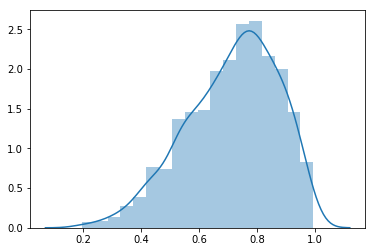

In [113]:
sns.distplot(np.random.beta(5,2,1000))